# VNPY Backtest Test

## Import Modules

In [1]:
from vnpy.app.cta_strategy.backtesting import BacktestingEngine, OptimizationSetting
from vnpy.app.cta_strategy.base import BacktestingMode
from datetime import datetime
from vnpy.trader.constant import Interval, Exchange
# from vnpy.app.atr_rsi_strategy import AtrRsiStrategy

from vnpy.app.portfolio_strategy.backtesting import BacktestingEngine as PairBacktestEngine

import matplotlib
%matplotlib inline

## Create my Method

In [3]:
import re


def getCommission(symbol,
                  exchange,
                  cost,
                  multiplier,
                  qty,
                  Real=False,
                  direction=''):
    """計算個別部位的單邊交易成本"""
    try:
        if exchange == 'TFE':
            if re.match('MTX[0-9]*', symbol):  # 小台指期
                return 50 + (1 * 50 + cost * (2 / 100000) * multiplier
                             ) * qty if not Real else 50 + (cost *
                                                            (2 / 100000) *
                                                            multiplier) * qty
            elif re.match('TX[0-9]*',
                          symbol) or re.match('TE[0-9]*', symbol) or re.match(
                              'TF[0-9]*', symbol):  # 大台指期
                return 50 + (1 * 200 + cost * (2 / 100000) * multiplier
                             ) * qty if not Real else 50 + (cost *
                                                            (2 / 100000) *
                                                            multiplier) * qty
            elif re.match(r"TX[O0-9][0-9]*[A-Z][0-9]", symbol):  # 台指選
                return 30 + (getMinimumTickOpt(cost) + cost * 2 /
                             100000) * qty * multiplier if not Real else 30 + (
                                 cost * 2 / 100000) * qty * multiplier
            elif re.match(r"[A-Z][A-Z]F[0-9][0-9]", symbol):  # 個股期貨
                return 50 + (
                    getMinimumTick(cost) + cost *
                    (2 / 100000)) * qty * multiplier if not Real else 50 + (
                        cost * (2 / 100000)) * qty * multiplier
        elif exchange == 'TSE':
            tick = getMinimumTick(cost)
            commission = cost * (0.1425 / 100) * multiplier
            commission = 20 if commission < 20 else commission
            fee = cost * (0.3 / 100) * multiplier
            slide = tick * multiplier
            if direction == 'EXIT' or direction == 0:
                return (commission + fee +
                        slide) * qty if not Real else (commission + fee) * qty
            else:
                return (commission +
                        slide) * qty if not Real else commission * qty
    except Exception as e:
        print(e)


def getMinimumTickOpt(cost):
    if cost < 10:
        return 0.1
    elif cost < 50:
        return 0.5
    elif cost < 500:
        return 1
    elif cost < 1000:
        return 5
    else:
        return 10


def getMinimumTick(cost):
    if cost < 10:
        return 0.01
    elif cost < 50:
        return 0.05
    elif cost < 100:
        return 0.1
    elif cost < 500:
        return 0.5
    elif cost < 1000:
        return 1
    else:
        return 5

## setup AtrRsiStrategy

In [5]:
from vnpy.app.cta_strategy.backtesting import BacktestingEngine, OptimizationSetting
from vnpy.app.cta_strategy import (
    CtaTemplate,
    StopOrder,
    TickData,
    BarData,
    TradeData,
    OrderData,
    BarGenerator,
    ArrayManager,
)


class AtrRsiStrategy(CtaTemplate):
    """"""

    author = "用Python的交易员"

    atr_length = 22
    atr_ma_length = 10
    rsi_length = 5
    rsi_entry = 16
    trailing_percent = 0.8
    fixed_size = 1

    atr_value = 0
    atr_ma = 0
    rsi_value = 0
    rsi_buy = 0
    rsi_sell = 0
    intra_trade_high = 0
    intra_trade_low = 0

    parameters = [
        "atr_length", "atr_ma_length", "rsi_length", "rsi_entry",
        "trailing_percent", "fixed_size"
    ]
    variables = [
        "atr_value", "atr_ma", "rsi_value", "rsi_buy", "rsi_sell",
        "intra_trade_high", "intra_trade_low"
    ]

    def __init__(self, cta_engine, strategy_name, vt_symbol, setting):
        """"""
        super().__init__(cta_engine, strategy_name, vt_symbol, setting)
        self.bg = BarGenerator(self.on_bar)
        self.am = ArrayManager()

    def on_init(self):
        """
        Callback when strategy is inited.
        """
        self.write_log("策略初始化")

        self.rsi_buy = 50 + self.rsi_entry
        self.rsi_sell = 50 - self.rsi_entry

        self.load_bar(10)

    def on_start(self):
        """
        Callback when strategy is started.
        """
        self.write_log("策略启动")

    def on_stop(self):
        """
        Callback when strategy is stopped.
        """
        self.write_log("策略停止")

    def on_tick(self, tick: TickData):
        """
        Callback of new tick data update.
        """
        self.bg.update_tick(tick)

    def on_bar(self, bar: BarData):
        """
        Callback of new bar data update.
        """
#         self.cancel_all()

        am = self.am
        am.update_bar(bar)
        if not am.inited:
            return

        atr_array = am.atr(self.atr_length, array=True)
        self.atr_value = atr_array[-1]
        self.atr_ma = atr_array[-self.atr_ma_length:].mean()
        self.rsi_value = am.rsi(self.rsi_length)

        if self.pos == 0:
            self.intra_trade_high = bar.high_price
            self.intra_trade_low = bar.low_price

            if self.atr_value > self.atr_ma:
                if self.rsi_value > self.rsi_buy:
                    self.buy(bar.close_price + 5, self.fixed_size)
                elif self.rsi_value < self.rsi_sell:
                    self.short(bar.close_price - 5, self.fixed_size)

        elif self.pos > 0:
            self.intra_trade_high = max(self.intra_trade_high, bar.high_price)
            self.intra_trade_low = bar.low_price

            long_stop = self.intra_trade_high * \
                (1 - self.trailing_percent / 100)
            self.sell(long_stop, abs(self.pos), stop=True)

        elif self.pos < 0:
            self.intra_trade_low = min(self.intra_trade_low, bar.low_price)
            self.intra_trade_high = bar.high_price

            short_stop = self.intra_trade_low * \
                (1 + self.trailing_percent / 100)
            self.cover(short_stop, abs(self.pos), stop=True)

        self.put_event()

    def on_order(self, order: OrderData):
        """
        Callback of new order data update.
        """
        pass

    def on_trade(self, trade: TradeData):
        """
        Callback of new trade data update.
        """
        self.put_event()

    def on_stop_order(self, stop_order: StopOrder):
        """
        Callback of stop order update.
        """
        pass

In [7]:
# from vnpy.trader.constant import Interval, Exchange
from functools import partial



tickers = '.TSE'
symbol, exchange = tickers.split('.')
get_commission = partial(getCommission, symbol=symbol, exchange=exchange)
engine = BacktestingEngine()

engine.set_parameters(
    vt_symbol=tickers,
    interval=Interval.DAILY,
    start=datetime(2008, 1, 1),
    end=datetime(2020, 6, 30),
    rate=get_commission,
    slippage=getMinimumTick,
    size=1000,
    pricetick=getMinimumTick,
    capital=1_000_000,
    mode=BacktestingMode.BAR,
    collection_name='TSE')

atrrsi_setting = {
    "atr_length":21, 
    "atr_ma_length":10, 
    "rsi_length":13, 
    "rsi_entry":30,
    "trailing_percent":0.8, 
    "fixed_size":1
}

engine.add_strategy(AtrRsiStrategy, atrrsi_setting)
engine.load_data()
engine.run_backtesting()
df = engine.calculate_result()
engine.calculate_statistics()
engine.show_chart()

2020-08-07 16:11:10.156516	开始加载历史数据
2020-08-07 16:11:11.057568	加载进度： [1%]
2020-08-07 16:11:11.102570	加载进度： [1%]
2020-08-07 16:11:11.261580	加载进度： [2%]
2020-08-07 16:11:11.305582	加载进度： [3%]
2020-08-07 16:11:11.440590	加载进度： [3%]
2020-08-07 16:11:11.476592	加载进度： [4%]
2020-08-07 16:11:11.492593	加载进度： [5%]
2020-08-07 16:11:11.510594	加载进度： [5%]
2020-08-07 16:11:11.533595	加载进度： [6%]
2020-08-07 16:11:11.555596	加载进度： [7%]
2020-08-07 16:11:11.571597	加载进度： [7%]
2020-08-07 16:11:11.581598	加载进度： [8%]
2020-08-07 16:11:11.588598	加载进度： [9%]
2020-08-07 16:11:11.630601	加载进度： [9%]
2020-08-07 16:11:11.643601	加载进度： [10%]
2020-08-07 16:11:11.662602	加载进度：# [11%]
2020-08-07 16:11:11.686604	加载进度：# [11%]
2020-08-07 16:11:11.721606	加载进度：# [12%]
2020-08-07 16:11:11.745607	加载进度：# [12%]
2020-08-07 16:11:11.784609	加载进度：# [13%]
2020-08-07 16:11:11.820611	加载进度：# [14%]
2020-08-07 16:11:11.840613	加载进度：# [14%]
2020-08-07 16:11:11.864614	加载进度：# [15%]
2020-08-07 16:11:11.905616	加载进度：# [16%]
2020-08-07 16:11:11.930618	加载进度：#

In [60]:
df[[bool(trade) for trade in df.trades]].trades[0]

[TradeData(gateway_name='BACKTESTING', symbol='1101', exchange=<Exchange.TSE: 'TSE'>, orderid='1', tradeid='1', direction=<Direction.SHORT: '空'>, offset=<Offset.OPEN: '开'>, price=40.9, volume=1, datetime=datetime.datetime(2008, 6, 30, 0, 0, tzinfo=<DstTzInfo 'Asia/Taipei' LMT+8:06:00 STD>))]

## setup PairTrading Strategy

In [10]:
from typing import List, Dict
from datetime import datetime

import numpy as np

from vnpy.app.portfolio_strategy import StrategyTemplate, StrategyEngine
from vnpy.trader.utility import BarGenerator
from vnpy.trader.object import TickData, BarData


class PairTradingStrategy(StrategyTemplate):
    """"""

    author = "用Python的交易员"

    price_add = 5
    boll_window = 20
    boll_dev = 2
    fixed_size = 1
    leg1_ratio = 1
    leg2_ratio = 1

    leg1_symbol = ""
    leg2_symbol = ""
    # last_spread = 0.0
    current_spread = 0.0
    boll_mid = 0.0
    boll_down = 0.0
    boll_up = 0.0

    parameters = [
        "price_add",
        "boll_window",
        "boll_dev",
        "fixed_size",
        "leg1_ratio",
        "leg2_ratio",
    ]
    variables = [
        "leg1_symbol",
        "leg2_symbol",
        "current_spread",
        "boll_mid",
        "boll_down",
        "boll_up",
    ]

    def __init__(self, strategy_engine: StrategyEngine, strategy_name: str,
                 vt_symbols: List[str], setting: dict):
        """"""
        super().__init__(strategy_engine, strategy_name, vt_symbols, setting)

        self.bgs: Dict[str, BarGenerator] = {}
        self.targets: Dict[str, int] = {}
        self.last_tick_time: datetime = None

        self.spread_count: int = 0
        self.spread_data: np.array = np.zeros(100)

        # Obtain contract info
        self.leg1_symbol, self.leg2_symbol = vt_symbols

        def on_bar(bar: BarData):
            """"""
            pass

        for vt_symbol in self.vt_symbols:
            self.targets[vt_symbol] = 0
            self.bgs[vt_symbol] = BarGenerator(on_bar)

    def on_init(self):
        """
        Callback when strategy is inited.
        """
        self.write_log("策略初始化")

        self.load_bars(1)

    def on_start(self):
        """
        Callback when strategy is started.
        """
        self.write_log("策略启动")

    def on_stop(self):
        """
        Callback when strategy is stopped.
        """
        self.write_log("策略停止")

    def on_tick(self, tick: TickData):
        """
        Callback of new tick data update.
        """
        if (self.last_tick_time
                and self.last_tick_time.minute != tick.datetime.minute):
            bars = {}
            for vt_symbol, bg in self.bgs.items():
                bars[vt_symbol] = bg.generate()
            self.on_bars(bars)

        bg: BarGenerator = self.bgs[tick.vt_symbol]
        bg.update_tick(tick)

        self.last_tick_time = tick.datetime

    def on_bars(self, bars: Dict[str, BarData]):
        """"""
        #         self.cancel_all()

        # Return if one leg data is missing
        if self.leg1_symbol not in bars or self.leg2_symbol not in bars:
            return

        # Calculate current spread
        leg1_bar = bars[self.leg1_symbol]
        leg2_bar = bars[self.leg2_symbol]

        # Filter time only run every 5 minutes
        #         if (leg1_bar.datetime.minute + 1) % 5:
        #             return

        self.current_spread = (leg1_bar.close_price * self.leg1_ratio -
                               leg2_bar.close_price * self.leg2_ratio)

        # Update to spread array
        self.spread_data[:-1] = self.spread_data[1:]
        self.spread_data[-1] = self.current_spread

        self.spread_count += 1
        if self.spread_count <= self.boll_window:
            return

        # Calculate boll value
        buf: np.array = self.spread_data[-self.boll_window:]

        std = buf.std()
        self.boll_mid = buf.mean()
        self.boll_up = self.boll_mid + self.boll_dev * std
        self.boll_down = self.boll_mid - self.boll_dev * std

        # Calculate new target position
        leg1_pos = self.get_pos(self.leg1_symbol)

        if not leg1_pos:
            if self.current_spread >= self.boll_up:
                self.targets[self.leg1_symbol] = -1
                self.targets[self.leg2_symbol] = 1
            elif self.current_spread <= self.boll_down:
                self.targets[self.leg1_symbol] = 1
                self.targets[self.leg2_symbol] = -1
        elif leg1_pos > 0:
            if self.current_spread >= self.boll_mid:
                self.targets[self.leg1_symbol] = 0
                self.targets[self.leg2_symbol] = 0
        else:
            if self.current_spread <= self.boll_mid:
                self.targets[self.leg1_symbol] = 0
                self.targets[self.leg2_symbol] = 0

        # Execute orders
        for vt_symbol in self.vt_symbols:
            target_pos = self.targets[vt_symbol]
            current_pos = self.get_pos(vt_symbol)

            pos_diff = target_pos - current_pos
            volume = abs(pos_diff)
            bar = bars[vt_symbol]

            if pos_diff > 0:
                price = bar.close_price + self.price_add

                if current_pos < 0:
                    self.cover(vt_symbol, price, volume)
                else:
                    self.buy(vt_symbol, price, volume)
            elif pos_diff < 0:
                price = bar.close_price - self.price_add

                if current_pos > 0:
                    self.sell(vt_symbol, price, volume)
                else:
                    self.short(vt_symbol, price, volume)

        self.put_event()

2020-08-07 16:23:14.984974	开始加载历史数据
2020-08-07 16:23:14.985974	2330.TSE加载进度： [1%]
2020-08-07 16:23:14.985974	2330.TSE加载进度： [1%]
2020-08-07 16:23:14.986974	2330.TSE加载进度： [2%]
2020-08-07 16:23:14.986974	2330.TSE加载进度： [3%]
2020-08-07 16:23:14.986974	2330.TSE加载进度： [3%]
2020-08-07 16:23:14.987974	2330.TSE加载进度： [4%]
2020-08-07 16:23:14.987974	2330.TSE加载进度： [5%]
2020-08-07 16:23:14.987974	2330.TSE加载进度： [5%]
2020-08-07 16:23:14.987974	2330.TSE加载进度： [6%]
2020-08-07 16:23:14.987974	2330.TSE加载进度： [7%]
2020-08-07 16:23:14.987974	2330.TSE加载进度： [7%]
2020-08-07 16:23:14.987974	2330.TSE加载进度： [8%]
2020-08-07 16:23:14.987974	2330.TSE加载进度： [9%]
2020-08-07 16:23:14.988974	2330.TSE加载进度： [9%]
2020-08-07 16:23:14.988974	2330.TSE加载进度： [10%]
2020-08-07 16:23:14.988974	2330.TSE加载进度：# [11%]
2020-08-07 16:23:14.988974	2330.TSE加载进度：# [11%]
2020-08-07 16:23:14.988974	2330.TSE加载进度：# [12%]
2020-08-07 16:23:14.988974	2330.TSE加载进度：# [12%]
2020-08-07 16:23:14.988974	2330.TSE加载进度：# [13%]
2020-08-07 16:23:14.988974	2330.T

2020-08-07 16:23:15.400998	数据缺失：2018-08-14 00:00:00 5403.TSE
2020-08-07 16:23:15.467002	历史数据回放结束
2020-08-07 16:23:15.469002	开始计算逐日盯市盈亏
2020-08-07 16:23:15.578008	逐日盯市盈亏计算完成
2020-08-07 16:23:15.580008	开始计算策略统计指标


E:\vnpy_env\vnpy\app\portfolio_strategy\backtesting.py:305: RuntimeWarning:

invalid value encountered in log

e:\vnpy_demo\lib\site-packages\pandas\plotting\_converter.py:278: MatplotlibDeprecationWarning:


The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.



2020-08-07 16:23:15.625011	------------------------------
2020-08-07 16:23:15.626011	首个交易日：	2008-01-02
2020-08-07 16:23:15.627011	最后交易日：	2020-06-30
2020-08-07 16:23:15.627011	总交易日：	3081
2020-08-07 16:23:15.628011	盈利交易日：	813
2020-08-07 16:23:15.628011	亏损交易日：	963
2020-08-07 16:23:15.629011	起始资金：	100,000.00
2020-08-07 16:23:15.629011	结束资金：	-95,514.60
2020-08-07 16:23:15.630011	总收益率：	-195.51%
2020-08-07 16:23:15.631011	年化收益：	-15.23%
2020-08-07 16:23:15.631011	最大回撤: 	-240,430.47
2020-08-07 16:23:15.631011	百分比最大回撤: -197.87%
2020-08-07 16:23:15.631011	最长回撤天数: 	2619
2020-08-07 16:23:15.631011	总盈亏：	-195,514.60
2020-08-07 16:23:15.631011	总手续费：	177,364.60
2020-08-07 16:23:15.631011	总滑点：	78,200.00
2020-08-07 16:23:15.631011	总成交金额：	34,218,750.00
2020-08-07 16:23:15.631011	总成交笔数：	428
2020-08-07 16:23:15.631011	日均盈亏：	-63.46
2020-08-07 16:23:15.631011	日均手续费：	57.57
2020-08-07 16:23:15.631011	日均滑点：	25.38
2020-08-07 16:23:15.631011	日均成交金额：	11,106.38
2020-08-07 16:23:15.631011	日均成交笔数：	0.1389159363842908
2

e:\vnpy_demo\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

e:\vnpy_demo\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.

e:\vnpy_demo\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

e:\vnpy_demo\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.



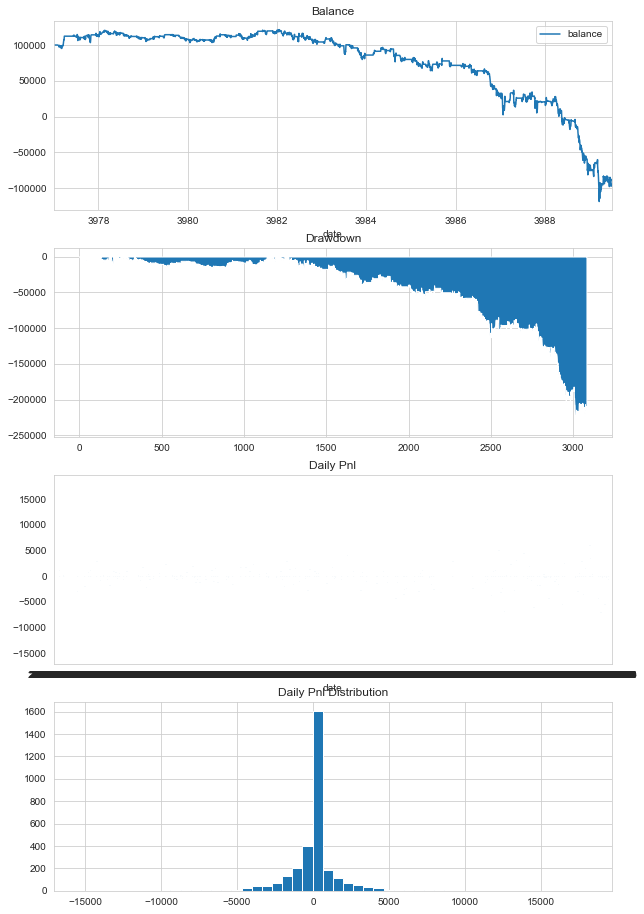

In [11]:
# from vnpy.trader.constant import Interval, Exchange
tickers = '2330.TSE,5403.TSE'.split(',')
pairengine = PairBacktestEngine()
pairengine.set_parameters(
    vt_symbols=tickers,
    interval=Interval.DAILY,
    start=datetime(2008, 1, 1),
    end=datetime(2020, 6, 30),
    rates=dict((ticker, getCommission) for ticker in tickers),
    slippages=dict((ticker, getMinimumTick) for ticker in tickers),
    sizes=dict((ticker, 1000) for ticker in tickers),
    priceticks=dict((ticker, getMinimumTick) for ticker in tickers),
    capital=100_000,
#     mode=BacktestingMode.BAR,
    collection_name=dict((ticker, 'TSE') for ticker in tickers))
pairengine.add_strategy(PairTradingStrategy, {})
pairengine.load_data()
pairengine.run_backtesting()
df = pairengine.calculate_result()
pairengine.calculate_statistics()
pairengine.show_chart()

## setup my Pair Trading Strategy

In [8]:
from typing import List, Dict
from datetime import datetime

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

from vnpy.app.portfolio_strategy import StrategyTemplate, StrategyEngine
from vnpy.trader.utility import BarGenerator
from vnpy.trader.object import TickData, BarData

zscore_last_array = pd.DataFrame([(float('NaN'))], columns=['Z Score'])
cadf_array = pd.DataFrame([(float('NaN'))], columns=['P-Value'])

class PairTradingStrategy(StrategyTemplate):
    """"""

    author = "Kevin at XQC"

#     price_add = getMinimumTick
    ols_window = 120
    zscore_high = 2
    zscore_low = 1
    boll_dev = 2
    fixed_size = 1
#     leg1_ratio = 1
#     leg2_ratio = 1
    leg1_close = []
    leg2_close = []

    leg1_symbol = ""
    leg2_symbol = ""
    # last_spread = 0.0
    current_spread = 0.0
    boll_mid = 0.0
    boll_down = 0.0
    boll_up = 0.0

    parameters = [
        "price_add",
        "boll_window",
        "boll_dev",
        "fixed_size",
        "leg1_ratio",
        "leg2_ratio",
    ]
    variables = [
        "leg1_symbol",
        "leg2_symbol",
        "current_spread",
        "boll_mid",
        "boll_down",
        "boll_up",
    ]

    def __init__(self, strategy_engine: StrategyEngine, strategy_name: str,
                 vt_symbols: List[str], setting: dict):
        """"""
        super().__init__(strategy_engine, strategy_name, vt_symbols, setting)

        self.bgs: Dict[str, BarGenerator] = {}
        self.targets: Dict[str, int] = {}
        self.last_tick_time: datetime = None

        # Obtain contract info
        self.leg1_symbol, self.leg2_symbol = vt_symbols

        def on_bar(bar: BarData):
            """"""
            pass

        for vt_symbol in self.vt_symbols:
            self.targets[vt_symbol] = 0
            self.bgs[vt_symbol] = BarGenerator(on_bar)

    def on_init(self):
        """
        Callback when strategy is inited.
        """
        self.write_log("策略初始化")

        self.load_bars(1)

    def on_start(self):
        """
        Callback when strategy is started.
        """
        self.write_log("策略启动")

    def on_stop(self):
        """
        Callback when strategy is stopped.
        """
        self.write_log("策略停止")

    def on_tick(self, tick: TickData):
        """
        Callback of new tick data update.
        """
        if (self.last_tick_time
                and self.last_tick_time.minute != tick.datetime.minute):
            bars = {}
            for vt_symbol, bg in self.bgs.items():
                bars[vt_symbol] = bg.generate()
            self.on_bars(bars)

        bg: BarGenerator = self.bgs[tick.vt_symbol]
        bg.update_tick(tick)

        self.last_tick_time = tick.datetime

    def on_bars(self, bars: Dict[str, BarData]):
        """"""
        #         self.cancel_all()
        global zscore_last_array, cadf_array

        # Return if one leg data is missing
        if self.leg1_symbol not in bars or self.leg2_symbol not in bars:
            return

        # Calculate current spread
        leg1_bar = bars[self.leg1_symbol]
        leg2_bar = bars[self.leg2_symbol]

        # Filter time only run every 5 minutes
        #         if (leg1_bar.datetime.minute + 1) % 5:
        #             return
        
        self.leg1_close.append(leg1_bar.close_price)
        self.leg2_close.append(leg2_bar.close_price)
        
        if len(self.leg1_close) >= self.ols_window and len(self.leg2_close) >= self.ols_window:
            
            # calculate hedge ratio
            self.hedge_ratio = sm.OLS(self.leg1_close, self.leg2_close).fit().params[0]
            
            # calculate spread
            spread = np.subtract(self.leg1_close, np.multiply(self.hedge_ratio, self.leg2_close))
            
            # calculate zscore
            z_score = ((spread - np.mean(spread))/np.std(spread))
            
            # record z score
            zscore_last_array = zscore_last_array.append(pd.DataFrame([z_score[-1]], columns=['Z Score']), ignore_index=True)
            
            # cointegration test
            cadf = ts.adfuller(z_score)[1]
            # record p-value
            cadf_array = cadf_array.append(pd.DataFrame([cadf], columns=['P-Value']), ignore_index=True)
            
            # set position
            self.calculate_xy_signals(bars, z_score[-1], cadf)
            self.leg1_close.pop(0)
            self.leg2_close.pop(0)
            
    def calculate_xy_signals(self, bars, zscore_last, cadf):

        hr = round(abs(self.hedge_ratio))
        
        # Calculate new target position
        leg1_pos = self.get_pos(self.leg1_symbol)
#         if abs(zscore_last) >= 2 or cadf <= 0.05:
#             print(zscore_last, cadf)
        if not leg1_pos:
            if zscore_last >= self.zscore_high and cadf <= 0.05:
                self.targets[self.leg1_symbol] = -1
                self.targets[self.leg2_symbol] = 1 * hr
            elif zscore_last <= -self.zscore_high and cadf <= 0.05:
                self.targets[self.leg1_symbol] = 1
                self.targets[self.leg2_symbol] = -1 * hr
        elif leg1_pos != 0:
            if abs(zscore_last) <= self.zscore_low and cadf <= 0.05 or cadf > 0.05:
                self.targets[self.leg1_symbol] = 0
                self.targets[self.leg2_symbol] = 0
        else:
            if cadf > 0.05:
                self.targets[self.leg1_symbol] = 0
                self.targets[self.leg2_symbol] = 0

        # Execute orders
        for vt_symbol in self.vt_symbols:
            target_pos = self.targets[vt_symbol]
            current_pos = self.get_pos(vt_symbol)

            pos_diff = target_pos - current_pos
            volume = abs(pos_diff)
            bar = bars[vt_symbol]

            if pos_diff > 0:
                price = bar.close_price + self.price_add(bar.close_price)

                if current_pos < 0:
                    self.cover(vt_symbol, price, volume)
                else:
                    self.buy(vt_symbol, price, volume)
            elif pos_diff < 0:
                price = bar.close_price - self.price_add(bar.close_price)

                if current_pos > 0:
                    self.sell(vt_symbol, price, volume)
                else:
                    self.short(vt_symbol, price, volume)

        self.put_event()
        
    def price_add(self, cost):
        return getMinimumTick(cost)

2020-08-06 12:15:49.824082	开始加载历史数据
2020-08-06 12:15:52.660244	2207.TSE加载进度： [1%]
2020-08-06 12:15:52.702247	2207.TSE加载进度： [1%]
2020-08-06 12:15:52.881257	2207.TSE加载进度： [2%]
2020-08-06 12:15:52.923259	2207.TSE加载进度： [3%]
2020-08-06 12:15:52.988263	2207.TSE加载进度： [3%]
2020-08-06 12:15:53.145272	2207.TSE加载进度： [4%]
2020-08-06 12:15:53.173274	2207.TSE加载进度： [5%]
2020-08-06 12:15:53.198275	2207.TSE加载进度： [5%]
2020-08-06 12:15:53.206276	2207.TSE加载进度： [6%]
2020-08-06 12:15:53.282280	2207.TSE加载进度： [7%]
2020-08-06 12:15:53.290280	2207.TSE加载进度： [7%]
2020-08-06 12:15:53.376285	2207.TSE加载进度： [8%]
2020-08-06 12:15:53.412287	2207.TSE加载进度： [9%]
2020-08-06 12:15:53.445289	2207.TSE加载进度： [9%]
2020-08-06 12:15:53.455290	2207.TSE加载进度： [10%]
2020-08-06 12:15:53.499292	2207.TSE加载进度：# [11%]
2020-08-06 12:15:53.596298	2207.TSE加载进度：# [11%]
2020-08-06 12:15:53.606298	2207.TSE加载进度：# [12%]
2020-08-06 12:15:53.652301	2207.TSE加载进度：# [12%]
2020-08-06 12:15:53.691303	2207.TSE加载进度：# [13%]
2020-08-06 12:15:53.706304	2207.T

2020-08-06 12:15:58.503579	2204.TSE加载进度：# [12%]
2020-08-06 12:15:58.541581	2204.TSE加载进度：# [12%]
2020-08-06 12:15:58.576583	2204.TSE加载进度：# [13%]
2020-08-06 12:15:58.591584	2204.TSE加载进度：# [14%]
2020-08-06 12:15:58.638586	2204.TSE加载进度：# [14%]
2020-08-06 12:15:58.655587	2204.TSE加载进度：# [15%]
2020-08-06 12:15:58.738592	2204.TSE加载进度：# [16%]
2020-08-06 12:15:58.785595	2204.TSE加载进度：# [16%]
2020-08-06 12:15:58.796595	2204.TSE加载进度：# [17%]
2020-08-06 12:15:58.849598	2204.TSE加载进度：# [18%]
2020-08-06 12:15:58.863599	2204.TSE加载进度：# [18%]
2020-08-06 12:15:58.871600	2204.TSE加载进度：# [19%]
2020-08-06 12:15:58.889601	2204.TSE加载进度：# [20%]
2020-08-06 12:15:58.943604	2204.TSE加载进度：## [20%]
2020-08-06 12:15:58.954604	2204.TSE加载进度：## [21%]
2020-08-06 12:15:58.971605	2204.TSE加载进度：## [22%]
2020-08-06 12:15:58.990606	2204.TSE加载进度：## [22%]
2020-08-06 12:15:59.003607	2204.TSE加载进度：## [23%]
2020-08-06 12:15:59.027609	2204.TSE加载进度：## [24%]
2020-08-06 12:15:59.052610	2204.TSE加载进度：## [24%]
2020-08-06 12:15:59.060610	2204.T

E:\vnpy_env\vnpy\app\portfolio_strategy\backtesting.py:305: RuntimeWarning: invalid value encountered in log
  df["return"] = np.log(df["balance"] / df["balance"].shift(1)).fillna(0)
e:\vnpy_demo\lib\site-packages\pandas\plotting\_converter.py:278: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0E9)
e:\vnpy_demo\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
e:\vnpy_demo\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visi

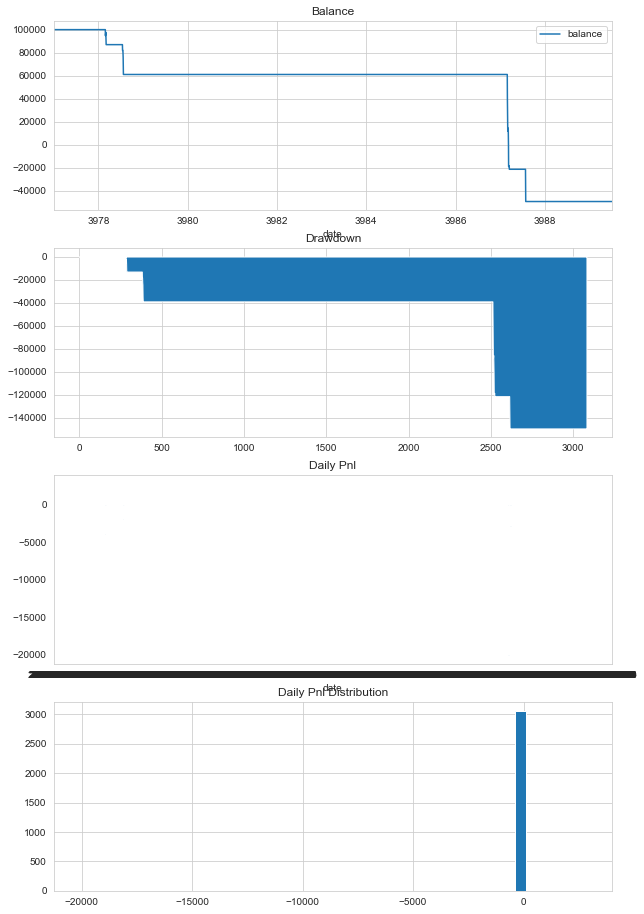

In [4]:
from vnpy.trader.constant import Interval, Exchange
tickers = '2207.TSE,2204.TSE'.split(',')
engine = PairBacktestingEngine()
engine.set_parameters(
    vt_symbols=tickers,
    interval=Interval.DAILY,
    start=datetime(2008, 1, 1),
    end=datetime(2020, 6, 30),
    rates=dict((ticker, getCommission) for ticker in tickers),
    slippages=dict((ticker, 1) for ticker in tickers),
    sizes=dict((ticker, 1000) for ticker in tickers),
    priceticks=dict((ticker, getMinimumTick) for ticker in tickers),
    capital=100_000,
#     mode=BacktestingMode.BAR,
    collection_name=dict((ticker, 'TSE') for ticker in tickers))
engine.add_strategy(PairTradingStrategy, {})
engine.load_data()
engine.run_backtesting()
df = engine.calculate_result()
engine.calculate_statistics()
engine.show_chart()

2020-08-07 16:19:22.265663	开始加载历史数据
2020-08-07 16:19:22.815695	2330.TSE加载进度： [1%]
2020-08-07 16:19:22.831696	2330.TSE加载进度： [1%]
2020-08-07 16:19:22.875698	2330.TSE加载进度： [2%]
2020-08-07 16:19:22.884699	2330.TSE加载进度： [3%]
2020-08-07 16:19:22.905700	2330.TSE加载进度： [3%]
2020-08-07 16:19:22.947702	2330.TSE加载进度： [4%]
2020-08-07 16:19:22.956703	2330.TSE加载进度： [5%]
2020-08-07 16:19:22.975704	2330.TSE加载进度： [5%]
2020-08-07 16:19:23.014706	2330.TSE加载进度： [6%]
2020-08-07 16:19:23.060709	2330.TSE加载进度： [7%]
2020-08-07 16:19:23.090711	2330.TSE加载进度： [7%]
2020-08-07 16:19:23.116712	2330.TSE加载进度： [8%]
2020-08-07 16:19:23.122712	2330.TSE加载进度： [9%]
2020-08-07 16:19:23.178716	2330.TSE加载进度： [9%]
2020-08-07 16:19:23.200717	2330.TSE加载进度： [10%]
2020-08-07 16:19:23.221718	2330.TSE加载进度：# [11%]
2020-08-07 16:19:23.229718	2330.TSE加载进度：# [11%]
2020-08-07 16:19:23.263720	2330.TSE加载进度：# [12%]
2020-08-07 16:19:23.301723	2330.TSE加载进度：# [12%]
2020-08-07 16:19:23.333724	2330.TSE加载进度：# [13%]
2020-08-07 16:19:23.364726	2330.T

2020-08-07 16:19:26.652914	5403.TSE加载进度：# [11%]
2020-08-07 16:19:26.669915	5403.TSE加载进度：# [11%]
2020-08-07 16:19:26.735919	5403.TSE加载进度：# [12%]
2020-08-07 16:19:26.759920	5403.TSE加载进度：# [12%]
2020-08-07 16:19:26.801923	5403.TSE加载进度：# [13%]
2020-08-07 16:19:26.816924	5403.TSE加载进度：# [14%]
2020-08-07 16:19:26.858926	5403.TSE加载进度：# [14%]
2020-08-07 16:19:26.881927	5403.TSE加载进度：# [15%]
2020-08-07 16:19:26.917929	5403.TSE加载进度：# [16%]
2020-08-07 16:19:26.944931	5403.TSE加载进度：# [16%]
2020-08-07 16:19:26.967932	5403.TSE加载进度：# [17%]
2020-08-07 16:19:26.992934	5403.TSE加载进度：# [18%]
2020-08-07 16:19:27.009935	5403.TSE加载进度：# [18%]
2020-08-07 16:19:27.021935	5403.TSE加载进度：# [19%]
2020-08-07 16:19:27.053937	5403.TSE加载进度：# [20%]
2020-08-07 16:19:27.076939	5403.TSE加载进度：## [20%]
2020-08-07 16:19:27.120941	5403.TSE加载进度：## [21%]
2020-08-07 16:19:27.130942	5403.TSE加载进度：## [22%]
2020-08-07 16:19:27.239948	5403.TSE加载进度：## [22%]
2020-08-07 16:19:27.250948	5403.TSE加载进度：## [23%]
2020-08-07 16:19:27.300951	5403.TSE

e:\vnpy_demo\lib\site-packages\pandas\plotting\_converter.py:278: MatplotlibDeprecationWarning:


The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.

e:\vnpy_demo\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

e:\vnpy_demo\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.

e:\vnpy_demo\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

e:\vnpy_demo\lib\site-packages\pandas\plotting\_tools.py:313: Matplotl

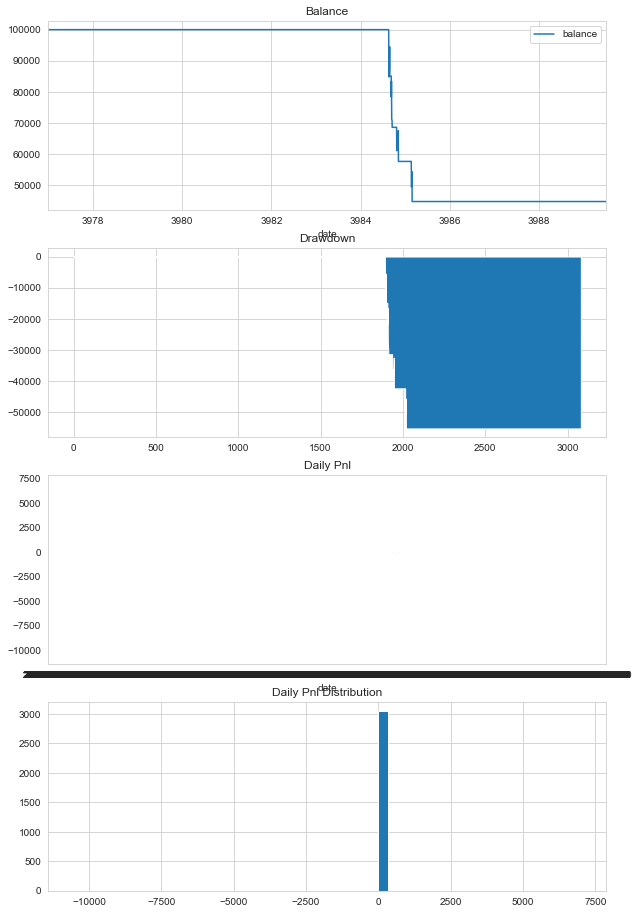

In [9]:
# from vnpy.trader.constant import Interval, Exchange
tickers = '2330.TSE,5403.TSE'.split(',')
pairengine = PairBacktestEngine()
pairengine.set_parameters(
    vt_symbols=tickers,
    interval=Interval.DAILY,
    start=datetime(2008, 1, 1),
    end=datetime(2020, 6, 30),
    rates=dict((ticker, getCommission) for ticker in tickers),
    slippages=dict((ticker, 1) for ticker in tickers),
    sizes=dict((ticker, 1000) for ticker in tickers),
    priceticks=dict((ticker, getMinimumTick) for ticker in tickers),
    capital=100_000,
#     mode=BacktestingMode.BAR,
    collection_name=dict((ticker, 'TSE') for ticker in tickers))
pairengine.add_strategy(PairTradingStrategy, {})
pairengine.load_data()
pairengine.run_backtesting()
df = pairengine.calculate_result()
pairengine.calculate_statistics()
pairengine.show_chart()

## setup bollChannelStrategy

In [20]:
BarGenerator.generate

In [27]:
from vnpy.app.cta_strategy import (
    CtaTemplate,
    StopOrder,
    TickData,
    BarData,
    TradeData,
    OrderData,
    BarGenerator,
    ArrayManager,
)


class BollChannelStrategy(CtaTemplate):
    """"""

    author = "用Python的交易员"

    boll_window = 18
    boll_dev = 3.4
    cci_window = 10
    atr_window = 30
    sl_multiplier = 5.2
    fixed_size = 1

    boll_up = 0
    boll_down = 0
    cci_value = 0
    atr_value = 0

    intra_trade_high = 0
    intra_trade_low = 0
    long_stop = 0
    short_stop = 0

    parameters = [
        "boll_window",
        "boll_dev",
        "cci_window",
        "atr_window",
        "sl_multiplier",
        "fixed_size"
    ]
    variables = [
        "boll_up",
        "boll_down",
        "cci_value",
        "atr_value",
        "intra_trade_high",
        "intra_trade_low",
        "long_stop",
        "short_stop"
    ]

    def __init__(self, cta_engine, strategy_name, vt_symbol, setting):
        """"""
        super().__init__(cta_engine, strategy_name, vt_symbol, setting)

        self.bg = BarGenerator(self.on_bar, 15, self.on_15min_bar, Interval.DAILY)
        self.am = ArrayManager()

    def on_init(self):
        """
        Callback when strategy is inited.
        """
        self.write_log("策略初始化")
        self.load_bar(10)

    def on_start(self):
        """
        Callback when strategy is started.
        """
        self.write_log("策略启动")

    def on_stop(self):
        """
        Callback when strategy is stopped.
        """
        self.write_log("策略停止")

    def on_tick(self, tick: TickData):
        """
        Callback of new tick data update.
        """
        self.bg.update_tick(tick)

    def on_bar(self, bar: BarData):
        """
        Callback of new bar data update.
        """
#         self.bg.update_bar(bar)        
        self.on_15min_bar(bar)

    def on_15min_bar(self, bar: BarData):
        """"""
#         self.cancel_all()

        am = self.am
        am.update_bar(bar)
        if not am.inited:
            return

        self.boll_up, self.boll_down = am.boll(self.boll_window, self.boll_dev)
        self.cci_value = am.cci(self.cci_window)
        self.atr_value = am.atr(self.atr_window)

        if self.pos == 0:
            self.intra_trade_high = bar.high_price
            self.intra_trade_low = bar.low_price

            if self.cci_value > 0:
                self.buy(self.boll_up, self.fixed_size, True)
            elif self.cci_value < 0:
                self.short(self.boll_down, self.fixed_size, True)

        elif self.pos > 0:
            self.intra_trade_high = max(self.intra_trade_high, bar.high_price)
            self.intra_trade_low = bar.low_price

            self.long_stop = self.intra_trade_high - self.atr_value * self.sl_multiplier
            self.sell(self.long_stop, abs(self.pos), True)

        elif self.pos < 0:
            self.intra_trade_high = bar.high_price
            self.intra_trade_low = min(self.intra_trade_low, bar.low_price)

            self.short_stop = self.intra_trade_low + self.atr_value * self.sl_multiplier
            self.cover(self.short_stop, abs(self.pos), True)

        self.put_event()

    def on_order(self, order: OrderData):
        """
        Callback of new order data update.
        """
        pass

    def on_trade(self, trade: TradeData):
        """
        Callback of new trade data update.
        """
        self.put_event()

    def on_stop_order(self, stop_order: StopOrder):
        """
        Callback of stop order update.
        """
        pass


In [7]:
from functools import partial

In [26]:
# from vnpy.trader.constant import Interval, Exchange

tickers = '2330.TSE'
symbol, exchange = tickers.split('.')
get_commission = partial(getCommission, symbol=symbol, exchange=exchange)
engine = BacktestingEngine()
engine.set_parameters(
    vt_symbol=tickers,
    interval=Interval.DAILY,
    start=datetime(2008, 1, 1),
    end=datetime(2020, 6, 30),
    rate=get_commission,
    slippage=getMinimumTick,
    size=1000,
    pricetick=getMinimumTick,
    capital=100_000,
    mode=BacktestingMode.BAR,
    collection_name='TSE')

boll_setting = {
    'boll_window' : 18,
    'boll_dev' : 2,
    'cci_window' : 10,
    'atr_window' : 30,
    'sl_multiplier' : 5.2,
    'fixed_size' : 1,
}
engine.add_strategy(BollChannelStrategy, boll_setting)
engine.load_data()
engine.run_backtesting()
df = engine.calculate_result()
engine.calculate_statistics()
engine.show_chart()

2020-08-06 15:49:07.635075	开始加载历史数据
2020-08-06 15:49:07.636075	加载进度： [1%]
2020-08-06 15:49:07.636075	加载进度： [1%]
2020-08-06 15:49:07.636075	加载进度： [2%]
2020-08-06 15:49:07.636075	加载进度： [3%]
2020-08-06 15:49:07.636075	加载进度： [3%]
2020-08-06 15:49:07.636075	加载进度： [4%]
2020-08-06 15:49:07.636075	加载进度： [5%]
2020-08-06 15:49:07.636075	加载进度： [5%]
2020-08-06 15:49:07.636075	加载进度： [6%]
2020-08-06 15:49:07.636075	加载进度： [7%]
2020-08-06 15:49:07.637075	加载进度： [7%]
2020-08-06 15:49:07.637075	加载进度： [8%]
2020-08-06 15:49:07.637075	加载进度： [9%]
2020-08-06 15:49:07.637075	加载进度： [9%]
2020-08-06 15:49:07.637075	加载进度： [10%]
2020-08-06 15:49:07.637075	加载进度：# [11%]
2020-08-06 15:49:07.637075	加载进度：# [11%]
2020-08-06 15:49:07.637075	加载进度：# [12%]
2020-08-06 15:49:07.637075	加载进度：# [12%]
2020-08-06 15:49:07.637075	加载进度：# [13%]
2020-08-06 15:49:07.637075	加载进度：# [14%]
2020-08-06 15:49:07.637075	加载进度：# [14%]
2020-08-06 15:49:07.637075	加载进度：# [15%]
2020-08-06 15:49:07.638075	加载进度：# [16%]
2020-08-06 15:49:07.638075	加载进度：#

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


## setup DoubleMAStrategy

In [22]:
from vnpy.app.cta_strategy import (
    CtaTemplate,
    StopOrder,
    TickData,
    BarData,
    TradeData,
    OrderData,
    BarGenerator,
    ArrayManager,
)


class DoubleMaStrategy(CtaTemplate):
    author = "用Python的交易员"

    fast_window = 10
    slow_window = 20

    fast_ma0 = 0.0
    fast_ma1 = 0.0

    slow_ma0 = 0.0
    slow_ma1 = 0.0

    parameters = ["fast_window", "slow_window"]
    variables = ["fast_ma0", "fast_ma1", "slow_ma0", "slow_ma1"]

    def __init__(self, cta_engine, strategy_name, vt_symbol, setting):
        """"""
        super().__init__(cta_engine, strategy_name, vt_symbol, setting)

        self.bg = BarGenerator(self.on_bar)
        self.am = ArrayManager()

    def on_init(self):
        """
        Callback when strategy is inited.
        """
        self.write_log("策略初始化")
        self.load_bar(10)

    def on_start(self):
        """
        Callback when strategy is started.
        """
        self.write_log("策略启动")
        self.put_event()

    def on_stop(self):
        """
        Callback when strategy is stopped.
        """
        self.write_log("策略停止")

        self.put_event()

    def on_tick(self, tick: TickData):
        """
        Callback of new tick data update.
        """
        self.bg.update_tick(tick)

    def on_bar(self, bar: BarData):
        """
        Callback of new bar data update.
        """

        am = self.am
        am.update_bar(bar)
        if not am.inited:
            return

        fast_ma = am.sma(self.fast_window, array=True)
        self.fast_ma0 = fast_ma[-1]
        self.fast_ma1 = fast_ma[-2]

        slow_ma = am.sma(self.slow_window, array=True)
        self.slow_ma0 = slow_ma[-1]
        self.slow_ma1 = slow_ma[-2]

        cross_over = self.fast_ma0 > self.slow_ma0 and self.fast_ma1 < self.slow_ma1
        cross_below = self.fast_ma0 < self.slow_ma0 and self.fast_ma1 > self.slow_ma1

        if cross_over:
            if self.pos == 0:
                self.buy(bar.close_price, 1)
            elif self.pos < 0:
                self.cover(bar.close_price, 1)
                self.buy(bar.close_price, 1)

        elif cross_below:
            if self.pos == 0:
                self.short(bar.close_price, 1)
            elif self.pos > 0:
                self.sell(bar.close_price, 1)
                self.short(bar.close_price, 1)

        self.put_event()

    def on_order(self, order: OrderData):
        """
        Callback of new order data update.
        """
        pass

    def on_trade(self, trade: TradeData):
        """
        Callback of new trade data update.
        """
        self.put_event()

    def on_stop_order(self, stop_order: StopOrder):
        """
        Callback of stop order update.
        """
        pass


In [66]:
# from vnpy.trader.constant import Interval, Exchange
from functools import partial



tickers = '2330.TSE'
symbol, exchange = tickers.split('.')
get_commission = partial(getCommission, symbol=symbol, exchange=exchange)
engine = BacktestingEngine()

engine.set_parameters(
    vt_symbol=tickers,
    interval=Interval.DAILY,
    start=datetime(2008, 1, 1),
    end=datetime(2020, 6, 30),
    rate=get_commission,
    slippage=getMinimumTick,
    size=1000,
    pricetick=getMinimumTick,
    capital=1_000_000,
    mode=BacktestingMode.BAR,
    collection_name='TSE')

engine.add_strategy(DoubleMaStrategy, {})
engine.load_data()
engine.run_backtesting()
df = engine.calculate_result()
engine.calculate_statistics()
engine.show_chart()

2020-08-06 18:07:23.601577	开始加载历史数据
2020-08-06 18:07:23.602577	加载进度： [1%]
2020-08-06 18:07:23.602577	加载进度： [1%]
2020-08-06 18:07:23.602577	加载进度： [2%]
2020-08-06 18:07:23.602577	加载进度： [3%]
2020-08-06 18:07:23.602577	加载进度： [3%]
2020-08-06 18:07:23.602577	加载进度： [4%]
2020-08-06 18:07:23.602577	加载进度： [5%]
2020-08-06 18:07:23.602577	加载进度： [5%]
2020-08-06 18:07:23.602577	加载进度： [6%]
2020-08-06 18:07:23.603577	加载进度： [7%]
2020-08-06 18:07:23.603577	加载进度： [7%]
2020-08-06 18:07:23.603577	加载进度： [8%]
2020-08-06 18:07:23.603577	加载进度： [9%]
2020-08-06 18:07:23.603577	加载进度： [9%]
2020-08-06 18:07:23.603577	加载进度： [10%]
2020-08-06 18:07:23.603577	加载进度：# [11%]
2020-08-06 18:07:23.603577	加载进度：# [11%]
2020-08-06 18:07:23.603577	加载进度：# [12%]
2020-08-06 18:07:23.603577	加载进度：# [12%]
2020-08-06 18:07:23.603577	加载进度：# [13%]
2020-08-06 18:07:23.604577	加载进度：# [14%]
2020-08-06 18:07:23.604577	加载进度：# [14%]
2020-08-06 18:07:23.604577	加载进度：# [15%]
2020-08-06 18:07:23.604577	加载进度：# [16%]
2020-08-06 18:07:23.604577	加载进度：#

## setup TurtleSignalStrategy

In [30]:
from vnpy.app.cta_strategy import (
    CtaTemplate,
    StopOrder,
    Direction,
    TickData,
    BarData,
    TradeData,
    OrderData,
    BarGenerator,
    ArrayManager,
)


class TurtleSignalStrategy(CtaTemplate):
    """"""
    author = "用Python的交易员"

    entry_window = 20
    exit_window = 10
    atr_window = 20
    fixed_size = 1

    entry_up = 0
    entry_down = 0
    exit_up = 0
    exit_down = 0
    atr_value = 0

    long_entry = 0
    short_entry = 0
    long_stop = 0
    short_stop = 0

    parameters = ["entry_window", "exit_window", "atr_window", "fixed_size"]
    variables = ["entry_up", "entry_down", "exit_up", "exit_down", "atr_value"]

    def __init__(self, cta_engine, strategy_name, vt_symbol, setting):
        """"""
        super().__init__(cta_engine, strategy_name, vt_symbol, setting)

        self.bg = BarGenerator(self.on_bar)
        self.am = ArrayManager()

    def on_init(self):
        """
        Callback when strategy is inited.
        """
        self.write_log("策略初始化")
        self.load_bar(20)

    def on_start(self):
        """
        Callback when strategy is started.
        """
        self.write_log("策略启动")

    def on_stop(self):
        """
        Callback when strategy is stopped.
        """
        self.write_log("策略停止")

    def on_tick(self, tick: TickData):
        """
        Callback of new tick data update.
        """
        self.bg.update_tick(tick)

    def on_bar(self, bar: BarData):
        """
        Callback of new bar data update.
        """
        self.cancel_all()

        self.am.update_bar(bar)
        if not self.am.inited:
            return

        # Only calculates new entry channel when no position holding
        if not self.pos:
            self.entry_up, self.entry_down = self.am.donchian(
                self.entry_window
            )

        self.exit_up, self.exit_down = self.am.donchian(self.exit_window)

        if not self.pos:
            self.atr_value = self.am.atr(self.atr_window)

            self.long_entry = 0
            self.short_entry = 0
            self.long_stop = 0
            self.short_stop = 0

            self.send_buy_orders(self.entry_up)
            self.send_short_orders(self.entry_down)
        elif self.pos > 0:
            self.send_buy_orders(self.entry_up)

            sell_price = max(self.long_stop, self.exit_down)
            self.sell(sell_price, abs(self.pos), True)

        elif self.pos < 0:
            self.send_short_orders(self.entry_down)

            cover_price = min(self.short_stop, self.exit_up)
            self.cover(cover_price, abs(self.pos), True)

        self.put_event()

    def on_trade(self, trade: TradeData):
        """
        Callback of new trade data update.
        """
        if trade.direction == Direction.LONG:
            self.long_entry = trade.price
            self.long_stop = self.long_entry - 2 * self.atr_value
        else:
            self.short_entry = trade.price
            self.short_stop = self.short_entry + 2 * self.atr_value

    def on_order(self, order: OrderData):
        """
        Callback of new order data update.
        """
        pass

    def on_stop_order(self, stop_order: StopOrder):
        """
        Callback of stop order update.
        """
        pass

    def send_buy_orders(self, price):
        """"""
        t = self.pos / self.fixed_size

        if t < 1:
            self.buy(price, self.fixed_size, True)

        if t < 2:
            self.buy(price + self.atr_value * 0.5, self.fixed_size, True)

        if t < 3:
            self.buy(price + self.atr_value, self.fixed_size, True)

        if t < 4:
            self.buy(price + self.atr_value * 1.5, self.fixed_size, True)

    def send_short_orders(self, price):
        """"""
        t = self.pos / self.fixed_size

        if t > -1:
            self.short(price, self.fixed_size, True)

        if t > -2:
            self.short(price - self.atr_value * 0.5, self.fixed_size, True)

        if t > -3:
            self.short(price - self.atr_value, self.fixed_size, True)

        if t > -4:
            self.short(price - self.atr_value * 1.5, self.fixed_size, True)


In [34]:
# from vnpy.trader.constant import Interval, Exchange
from functools import partial



tickers = '3008.TSE'
symbol, exchange = tickers.split('.')
get_commission = partial(getCommission, symbol=symbol, exchange=exchange)
engine = BacktestingEngine()

engine.set_parameters(
    vt_symbol=tickers,
    interval=Interval.DAILY,
    start=datetime(2008, 1, 1),
    end=datetime(2020, 6, 30),
    rate=get_commission,
    slippage=getMinimumTick,
    size=1000,
    pricetick=getMinimumTick,
    capital=1_000_000,
    mode=BacktestingMode.BAR,
    collection_name='TSE')

engine.add_strategy(TurtleSignalStrategy, {})
engine.load_data()
engine.run_backtesting()
df = engine.calculate_result()
engine.calculate_statistics()
engine.show_chart()

2020-08-06 16:40:02.802821	开始加载历史数据
2020-08-06 16:40:02.802821	加载进度： [1%]
2020-08-06 16:40:02.803821	加载进度： [1%]
2020-08-06 16:40:02.803821	加载进度： [2%]
2020-08-06 16:40:02.803821	加载进度： [3%]
2020-08-06 16:40:02.803821	加载进度： [3%]
2020-08-06 16:40:02.803821	加载进度： [4%]
2020-08-06 16:40:02.803821	加载进度： [5%]
2020-08-06 16:40:02.803821	加载进度： [5%]
2020-08-06 16:40:02.803821	加载进度： [6%]
2020-08-06 16:40:02.803821	加载进度： [7%]
2020-08-06 16:40:02.803821	加载进度： [7%]
2020-08-06 16:40:02.803821	加载进度： [8%]
2020-08-06 16:40:02.803821	加载进度： [9%]
2020-08-06 16:40:02.803821	加载进度： [9%]
2020-08-06 16:40:02.803821	加载进度： [10%]
2020-08-06 16:40:02.803821	加载进度：# [11%]
2020-08-06 16:40:02.803821	加载进度：# [11%]
2020-08-06 16:40:02.803821	加载进度：# [12%]
2020-08-06 16:40:02.803821	加载进度：# [12%]
2020-08-06 16:40:02.804821	加载进度：# [13%]
2020-08-06 16:40:02.804821	加载进度：# [14%]
2020-08-06 16:40:02.804821	加载进度：# [14%]
2020-08-06 16:40:02.804821	加载进度：# [15%]
2020-08-06 16:40:02.804821	加载进度：# [16%]
2020-08-06 16:40:02.804821	加载进度：#